In [1]:
from importlib import reload
import methods
import warnings
import pickle

import pandas as pd
from daps import *

In [2]:
reload(methods)
from methods import *

In [3]:
#get the list of proteins names from the 'pdb' directory of protein structures

dataset = 'nlrome'
directory = 'pdb'
filenames = get_files_with_ext(directory, '.pdb')
protlist = [os.path.splitext(file)[0] for file in filenames]

In [78]:
#save plot of regression for each protein and save LRR annotation start/end into the dictionary cutoff_d. plot_regression returns standard deviation of middle line segment in regression.
#only can run next cell in lieu of this if already computed pickles

cutoff_d = {}
std_d = {}
for protid in protlist:
    preX = get_backbone_from_pdb(f'pdb/{protid}.pdb')
    winding, m, parameters = get_regression(preX)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        stddev = plot_regression(winding, parameters, m, save = True, filename = f'plot/regression/{protid}')
        std_d[protid] = stddev
        cutoff_d[protid] = tuple(parameters.astype('int'))
with open('pickles/cutoff_d.pickle', 'wb') as handle:
    pickle.dump(cutoff_d, handle)
with open('pickles/std_d.pickle', 'wb') as handle:
    pickle.dump(std_d, handle)    

In [4]:
'''alternative to previous cell: load dictionary from pickles'''

with open('pickles/cutoff_d.pickle', 'rb') as handle:
    cutoff_d = pickle.load(handle)    
with open('pickles/std_d.pickle', 'rb') as handle:
    std_d = pickle.load(handle)    

(array([17., 19., 33., 14., 15., 14., 13., 10., 11.,  4.,  6.,  2.,  3.,
         1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
         2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.0491697 , 0.09330121, 0.13743271, 0.18156422, 0.22569573,
        0.26982724, 0.31395875, 0.35809026, 0.40222176, 0.44635327,
        0.49048478, 0.53461629, 0.5787478 , 0.6228793 , 0.66701081,
        0.71114232, 0.75527383, 0.79940534, 0.84353685, 0.88766835,
        0.93179986, 0.97593137, 1.02006288, 1.06419439, 1.10832589,
        1.1524574 , 1.19658891, 1.24072042, 1.28485193, 1.32898343,
        1.37311494, 1.41724645, 1.46137796, 1.50550947, 1.54964098,
        1.59377248, 1.63790399, 1.6820355 , 1.72616701, 1.77029852,
        1.81443002, 1.85856153, 1.90269304, 1.94682455, 1.99095606,
        2.03508757, 2.07921907, 2.12335058, 2.16748209, 2.2116136 ,
        2.25574511]),
 <BarContainer

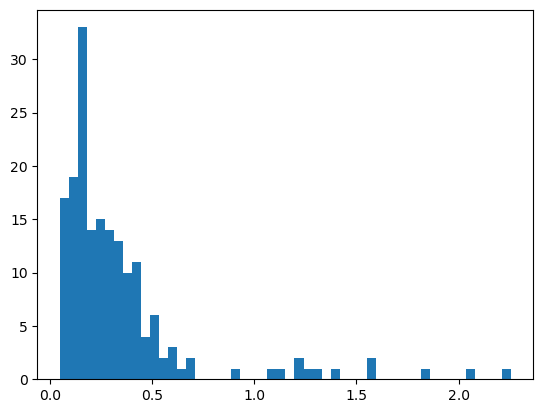

In [6]:
#visualize distribution of standard deviations to determine which regressions turned out badly and require multi-breakpoint
plt.hist(list(std_d.values()), bins = 50)

In [7]:
#run 4-breakpoint regression and save plots folder
multi_parameters = {}
for protid in protlist:
    if std_d[protid] > .7:
        preX = get_backbone_from_pdb(f'pdb/{protid}.pdb')
        a, b = cutoff_d[protid]
        winding, m, parameters = multi_regression(preX, a, b)
        plot_regression_multi(winding, parameters, m, filename = f'plot/piecewise_multi/{protid}', save = True)
# with open('pickles/multi_parameters.pickle', 'wb') as handle:
#     pickle.dump(multi_parameters, handle)

KeyboardInterrupt: 

In [6]:
#collect lrrpredictor outputs into a dictionary
df = pd.read_csv('LRRPredictor_output/col-0-nlrome.txt', delimiter = '\t')
motifs_d = {}
for protid in protlist:
    motifs = []
    foundProtein = False
    for ii in range(len(df)):
        if '.'.join(df['annotation'][ii].split('_')[1:]) == protid:
            foundProtein = True
        elif foundProtein:            
            break
        if foundProtein:
            motifs.append(int(df['start'][ii]))
    motifs_d[protid] = motifs

In [16]:
#computes the discrepancy of a protein and shows plot of the grid

discrep_d = {}

for ii, protid in enumerate(motifs_d):
    fileid = protid.replace(' ', '')
    preX = get_backbone_from_pdb(f'{directory}/{fileid}.pdb')

    winding, s, c, q, dx = get_winding(preX)
    a, b = cutoff_d[protid]

    motifs = motifs_d[protid]

    verticals = np.array([p for p in motifs if a <= p <= b])
    if not list(verticals):
        continue
    lrr_heights = winding[verticals]
    k = len(lrr_heights)

    u = 1 + np.zeros(k)
    v = np.arange(0.0, k)

    v -= (u @ v) / (u @ u) * u
    z = (lrr_heights @ u) / (u @ u) * u + (lrr_heights @ v) / (v @ v) * v
    diff = np.sign(np.mean(z[1:] - z[:-1]))
    projected = diff * v + (z @ u) / (u @ u) * u
    discrep = np.mean((projected - lrr_heights) ** 2)
    # hs = np.arange(int(min(winding[a:b])) + g, int(max(winding[a:b]))) + g
    hs = projected
    # vs = np.array(motifs_d[protid])
    vs = np.array(verticals)
    ext_vs = set(motifs_d[protid]) - set(vs)
    # plt.hlines(hs, xmin = a, xmax = b, color = 'purple', ls = '--')

    discrep_d[protid] = discrep

    continue

    plt.hlines(projected, xmin = a, xmax = b, color = 'purple', ls = '--')

    for vert in vs:
        plt.axvline(vert, color = 'orange', ls = '--')
    for vert in ext_vs:
        plt.axvline(vert, color = 'red', ls = '--')
        
    plt.axvline(a, color = 'black')
    plt.axvline(b, color = 'black')
    plt.plot(winding)
    plt.title(f'LRR Discrep: {discrep:.6}')
    plt.show()

plt.hist(discrep_d.values(), bins = 100)

with open('pickles/discrep_d_athaliana.pickle', 'wb') as handle:
    pickle.dump(discrep_d, handle)    

In [11]:
#compute graph laplacian eigenvectors

for ii, protid in enumerate(motifs_d):
    fileid = protid

    motifs = motifs_d[protid]

    a, b = cutoff_d[protid]
    #truncate protein
    X = get_backbone_from_pdb(f'pdb/{protid}.pdb')[a:b]
    
    period = 25

    #truncate protein
    X = get_curv_vectors(X, MaxOrder=1, sigma=1)[1]
    # np.save(make_path('npy', 'nlrome_X', '%s.npy'%tairid), X)        
    #print out the number of residues in the chain, and print the locations of the LRR motif residues
    D = get_csm(X, X)
    # Clean up the matrix a bit by doing a sliding window of length roughly the period
    D = sliding_window(D, period)
    # Clean up the matrix even more by binarizing it with nearest neighbors
    B = csm_to_binary_mutual(D, 50)
    #B = B[0:400, 0:400]
    v = getUnweightedLaplacianEigsDense(1-B)

    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.imshow(D, cmap='magma_r')
    plt.title("Self-Similarity Matrix")
    plt.subplot(132)
    plt.imshow(B)
    plt.title("Binarized Self-Similarity Matrix")
    plt.subplot(133)
    plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
    for motif in motifs:
        motif -= a
        if motif in range(v.shape[0]):
            plt.axhline(motif)
    plt.title("Eigenvectors of Unweighted Graph Laplacian")
    plt.savefig(make_path('plot','eigenmatrix_nlrome', '%s.png'%protid))
    plt.close()
    np.save(make_path('npy', 'eigenmatrix_nlrome', '%s.npy'%protid), v)
    continue
    plt.show()

In [12]:
for protid in motifs_d:
    motifs = motifs_d[protid]
    if len(motifs)<2:
        continue
    period = 25
    v = np.load(f'npy/eigenmatrix_{dataset}/%s.npy'%protid)
    s = v[:,0]
    c = v[:,1]
    sf = detrend_timeseries(s, period)
    cf = detrend_timeseries(c, period)

    theta = np.arctan2(cf, sf)
    # plt.figure(figsize=(12, 4))
    # plt.plot(theta, label=f'{eig1}, {eig2}')

    # phases = []
    # for res in motifs_l:
    #     if res in range(len(theta)):
    #         plt.plot(res, theta[res], 'bo')
    #         phases.append(theta[res])

    plt.figure(figsize=(12, 4))
    plt.title(f"Estimated phase for LRR of {protid}")
    plt.ylabel('Angle')
    plt.xlabel('LRR coil residue number')

    plt.plot(theta)

    for res in motifs:
        res -= a
        if res in range(len(theta)):
            plt.plot(res, theta[res], 'ro')
    # plt.show()
    # break

    plt.savefig(make_path('plot', f'phase_estimation_{dataset}', f'{protid}.png'))
    plt.close()


In [14]:
#sliding window of l2 distance. need to move some of this to methods.py
for protid in motifs_d:
    v = np.load(f'npy/eigenmatrix_{dataset}/%s.npy'%protid)

    s = v[:,0]
    c = v[:,1]

    winding, swl2, slope = get_winding_swl2(s,c)
    # bins = np.linspace(min(swl2), max(swl2), 100)
    # scores = np.digitize(swl2, bins, 100)/100

    offset = np.mean(winding - slope*np.arange(len(winding)))

    plt.figure(figsize=(12, 6))
    plt.subplot(311)
    plt.plot(s)
    plt.plot(c)
    plt.title("Leading eigenvectors for %s"%protid)
    plt.subplot(312)
    plt.plot(winding)
    plt.plot(slope*np.arange(len(winding))-offset, c = 'grey', linestyle = '--')
    plt.title("Winding number vs median slope")
    plt.subplot(313)
    plt.plot(swl2)
    plt.title("Sliding window L2 distance")    
    plt.tight_layout()

    # plt.show()

    plt.savefig(make_path('plot', 'swl2', f'{protid}.png'))
    plt.close()
